# Alternating current - acausal circuit modeling #
#### Ann Arbor Scientific and Technical Computing, March 25th 2021
#### Presented by David Perner
<img src="img/2880px-RC_Series_Filter_(with_V&I_Labels).svg.png" style="width:600px"></img>

## So what is acausal modeling? ##

In short, acausal modeling is a way of defining a system based more on the relationships between the components without assuming how power (or any transient quantity) might flow between them. This could be preferable in a number of situations including
- Physical systems where flow direction often reverses (think propulsion and regenerative braking in electric cars)
- Times when the modeler prefers to perserve the physical layout of the components instead of rearranging them mathematically (think these circuits and how we can wire them together in code to resemble to the diagrams)

A decent comparison is given in the lecture notes for a Berkeley class [Principles of Acausal Modeling Languages](https://bcourses.berkeley.edu/files/46075428/download?download_frd=1).

Below is an example and starting point from [ModelingToolkit.jl](https://mtk.sciml.ai/stable/tutorials/acausal_components/). We'll be building a circuit similar to the one in the intro, with a capacitor and resistor in series.

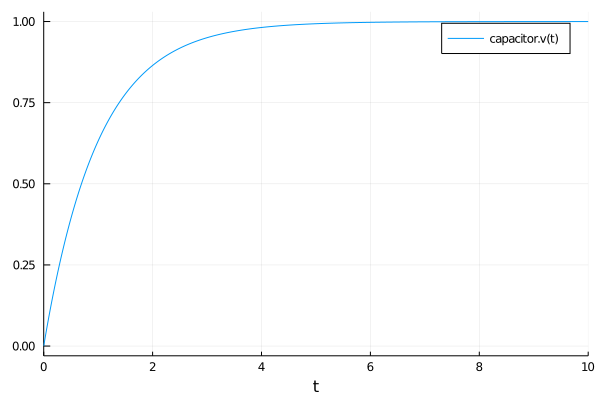

In [1]:
using ModelingToolkit, Plots, DifferentialEquations

@parameters t

# Basic electric components
function Pin(;name)
    @variables v(t) i(t)
    ODESystem(Equation[], t, [v, i], [], name=name, defaults=[v=>1.0, i=>1.0])
end

function Ground(;name)
    @named g = Pin()
    eqs = [g.v ~ 0]
    ODESystem(eqs, t, [], [], systems=[g], name=name)
end

function Resistor(;name, R = 1.0)
    val = R
    @named p = Pin()
    @named n = Pin()
    @variables v(t)
    @parameters R
    eqs = [
           v ~ p.v - n.v
           0 ~ p.i + n.i
           v ~ p.i * R
          ]
    ODESystem(eqs, t, [v], [R], systems=[p, n], defaults=Dict(R => val), name=name)
end

function Capacitor(; name, C = 1.0)
    val = C
    @named p = Pin()
    @named n = Pin()
    @variables v(t)
    @parameters C
    D = Differential(t)
    eqs = [
           v ~ p.v - n.v
           0 ~ p.i + n.i
           D(v) ~ p.i / C
          ]
    ODESystem(eqs, t, [v], [C], systems=[p, n], defaults=Dict(C => val), name=name)
end

function ConstantVoltage(;name, V = 1.0)
    val = V
    @named p = Pin()
    @named n = Pin()
    @parameters V
    eqs = [
           V ~ p.v - n.v
           0 ~ p.i + n.i
          ]
    ODESystem(eqs, t, [], [V], systems=[p, n], defaults=Dict(V => val), name=name)
end

R = 1.0
C = 1.0
V = 1.0
@named resistor = Resistor(R=R)
@named capacitor = Capacitor(C=C)
@named source = ConstantVoltage(V=V)
@named ground = Ground()

function connect_pins(ps...)
    eqs = [
           0 ~ sum(p->p.i, ps) # KCL
          ]
    # KVL
    for i in 1:length(ps)-1
        push!(eqs, ps[i].v ~ ps[i+1].v)
    end

    return eqs
end

rc_eqs = [
          connect_pins(source.p, resistor.p)
          connect_pins(resistor.n, capacitor.p)
          connect_pins(capacitor.n, source.n, ground.g)
         ]

@named rc_model = ODESystem(rc_eqs, t,
                            systems=[resistor, capacitor, source, ground])
sys = structural_simplify(rc_model)
u0 = [
      capacitor.v => 0.0
      capacitor.p.i => 0.0
     ]
prob = ODAEProblem(sys, u0, (0, 10.0))
sol = solve(prob, Tsit5())
plot(sol)

In [2]:
rc_eqs

7-element Array{Equation,1}:
 0 ~ resistor₊p₊i(t) + source₊p₊i(t)
 source₊p₊v(t) ~ resistor₊p₊v(t)
 0 ~ capacitor₊p₊i(t) + resistor₊n₊i(t)
 resistor₊n₊v(t) ~ capacitor₊p₊v(t)
 0 ~ capacitor₊n₊i(t) + ground₊g₊i(t) + source₊n₊i(t)
 capacitor₊n₊v(t) ~ source₊n₊v(t)
 source₊n₊v(t) ~ ground₊g₊v(t)

In [3]:
sys

Model rc_model with 2 equations
States (2):
  capacitor₊v(t)
  capacitor₊p₊i(t) [defaults to 1.0]
Parameters (3):
  resistor₊R [defaults to 1.0]
  capacitor₊C [defaults to 1.0]
  source₊V [defaults to 1.0]
Incidence matrix:
  [1, 1]  =  ×
  [2, 2]  =  ×
  [1, 3]  =  ×
  [2, 3]  =  ×

Let's trying to add some new components to this mix though. What would happen, for instance, if we had alternating current instead of the constant source we've been using?

In [4]:
function AlternatingVoltage(;name, Vpeak = 1.0, ω=1.0, ϕ=0.0)
    val1 = Vpeak
    val2 = ω
    val3 = ϕ
    @named p = Pin()
    @named n = Pin()
    @parameters Vpeak ω ϕ
    @variables v(t)
    eqs = [
           v ~ p.v - n.v
           0 ~ p.i + n.i
           v ~ Vpeak*sin(ω*t + ϕ)
          ]
    ODESystem(eqs, t, [v], [Vpeak, ω, ϕ], systems=[p, n], defaults=[Vpeak => val1, ω=>val2, ϕ=>val3], name=name)
end

AlternatingVoltage (generic function with 1 method)

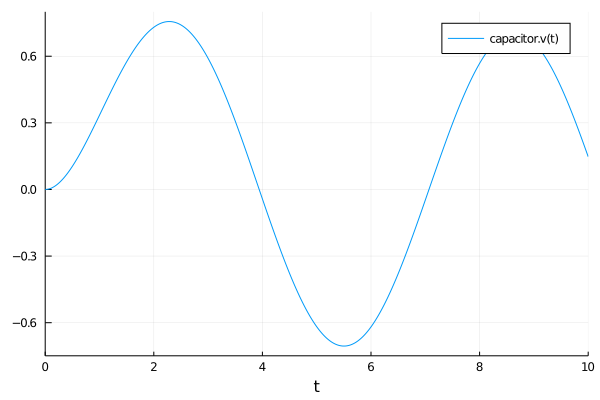

In [5]:
@named ac_source = AlternatingVoltage(Vpeak=1.0, ω=1.0)

ac_rc_eqs = [
          connect_pins(ac_source.p, resistor.p)
          connect_pins(resistor.n, capacitor.p)
          connect_pins(capacitor.n, ac_source.n, ground.g)
         ]

@named ac_rc_model = ODESystem(ac_rc_eqs, t,
                            systems=[resistor, capacitor, ac_source, ground])
sys = structural_simplify(ac_rc_model)
u0 = [
      capacitor.v => 0.0
      capacitor.p.i => 0.0
     ]
prob = ODAEProblem(sys, u0, (0, 10.0))
sol = solve(prob, Tsit5())
plot(sol)

We can see that this does give us a sinusoidal wave like we expected, but also the magnitude of the wave is less than the source. This is because we've also created a first order low-pass filter. This means that lower frequencies are "passed" through the filter without much attenuation, but higher frequencies are filtered out. This is an extremely useful ability for, say, audio engineering where a lot of noise but not a lot of signal tends to be at higher frequencies.
<img src="img/2560px-1st_Order_Lowpass_Filter_RC.svg.png" style="width:600px"></img>

In [53]:
filt_mag = []
pow_range = range(-3,3,length=100)
freq_range = 10.0.^pow_range

for ω in freq_range
    @named ac_source = AlternatingVoltage(ω=ω)

    ac_rc_eqs = [
              connect_pins(ac_source.p, resistor.p)
              connect_pins(resistor.n, capacitor.p)
              connect_pins(capacitor.n, ac_source.n, ground.g)
             ]

    @named ac_rc_model = ODESystem(ac_rc_eqs, t,
                                systems=[resistor, capacitor, ac_source, ground])
    sys = structural_simplify(ac_rc_model)
    u0 = [
          capacitor.v => 0.0
          capacitor.p.i => 0.0
         ]
    prob = ODAEProblem(sys, u0, (0, 2π/ω))
    sol = solve(prob, Tsit5())
    push!(filt_mag, maximum(sol[capacitor.v]))
end

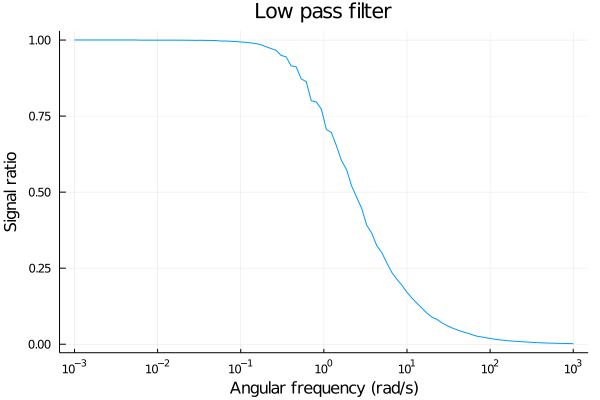

In [54]:
plot(freq_range,filt_mag,
    xlabel="Angular frequency (rad/s)",
    ylabel="Signal ratio", 
    title="Low pass filter",
    xaxis=:log,
    legend=nothing)

Also, with some rearranging, we can create a high pass filter. As you may have guessed, it does much the opposite of the low pass and filters out low frequencies while passing through high frequencies.
<img src="img/2880px-High_pass_filter.svg.png" style="width:600px"></img>

In [55]:
filt_mag = []
pow_range = range(-3,3,length=100)
freq_range = 10.0.^pow_range

for ω in freq_range
    @named ac_source = AlternatingVoltage(ω=ω)

    ac_rc_eqs = [
              connect_pins(ac_source.p, capacitor.p)
              connect_pins(capacitor.n, resistor.p)
              connect_pins(resistor.n, ac_source.n, ground.g)
             ]

    @named ac_rc_model = ODESystem(ac_rc_eqs, t,
                                systems=[resistor, capacitor, ac_source, ground])
    sys = structural_simplify(ac_rc_model)
    u0 = [
          capacitor.v => 0.0
          capacitor.p.i => 0.0
         ]
    prob = ODAEProblem(sys, u0, (0, 2π/ω))
    sol = solve(prob, Tsit5())
    push!(filt_mag, maximum(sol[resistor.v]))
end

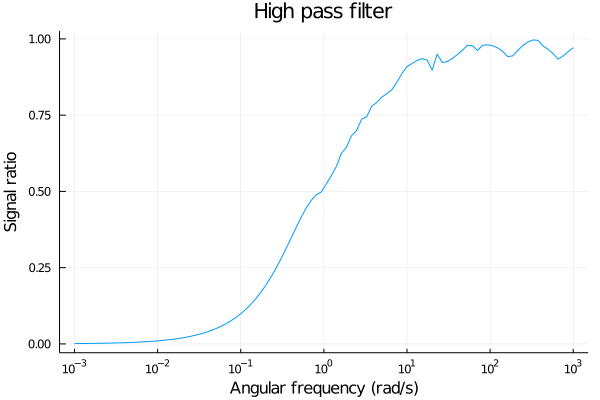

In [56]:
plot(freq_range,filt_mag,
    xlabel="Angular frequency (rad/s)",
    ylabel="Signal ratio", 
    xaxis=:log,
    title="High pass filter",
    legend=nothing)

## Final thoughts ##
Although these are pretty simple circuits, they demonstrate the power of acausal modeling to capture non-trivial behaviors in a (perhaps) easier to understand format. However, the quality of these results depends heavily on the quality of the ODE solution and solver (see the jagged high pass filter trend) and may be poorly suited to some situations. For instance, these filter results are much more easily and neatly derived from the equations of the system, rather than essentially "by experiment" here. Still, many dynamic systems are far more complicated, and in that case it might be far more difficult to find an analytical solution. As always, it's important for anyone building models to consider the right tools for the right job.

Below are some components I was trying to get working, but couldn't quite make happen. They allow a number of extremely interesting circuits to be built, so I may try posting these as issues on the `ModelingToolkit.jl` website, if only because it *seems* like they should work.

In [7]:
# function Inductor(;name, L=1.0)
#     val = L
#     @named p = Pin()
#     @named n = Pin()
#     @variables v(t)
#     @parameters L  
#     D = Differential(t)
#     eqs = [
#         v ~ p.v - n.v
#         0 ~ p.i + n.i
#         D(p.i) ~ -v/L
#     ]
#     ODESystem(eqs, t, [v], [L], systems=[p, n], defaults=Dict(L => val), name=name)
# end

# @named inductor = Inductor(L=1.0)

# lc_eqs = [
#           connect_pins(capacitor.n, inductor.p)
#           connect_pins(inductor.n, capacitor.p)
#          ]

# @named lc_model = ODESystem(lc_eqs, t,
#                             systems=[inductor, capacitor])
# # sys = structural_simplify(lc_model)
# u0 = [
#         capacitor.v => 1.0
#         capacitor.p.i => 0.0
#         inductor.v=>0.0
#         inductor.n.i=>0.0
#      ]
# prob = ODEProblem(lc_model, u0, (0, 10.0))
# sol = solve(prob, Tsit5())
# plot(sol)

######################################################################################

# function IdealDiode(;name, Is=0.2e-3, Vt = 25.8563e-3, qf=1.0)
#     val1 = Is
#     val2 = Vt
#     val3 = qf
#     @named p = Pin()
#     @named n = Pin()
#     @parameters Is Vt qf
#     @variables i(t) v(t)
#     eqs = [
#         v ~ p.v - n.v
#         i ~ p.i + n.i
#         i ~ Is*(exp(v/(qf*Vt)) - 1.0)
#     ]
#     ODESystem(eqs, t, [v, i], [Is, Vt, qf], systems=[p, n], defaults=[Is => val1, Vt=>val2, qf=>val3], name=name)
# end

# @named diode = IdealDiode()

# ac_diode_eqs = [
#           connect_pins(ac_source.p, resistor.p)
#           connect_pins(resistor.n, diode.p)
#           connect_pins(diode.n, ac_source.n, ground.g)
#          ]

# @named ac_diode_model = ODESystem(ac_diode_eqs, t,
#                             systems=[resistor, diode, ac_source, ground])
# sys = structural_simplify(ac_diode_model)
# u0 = [
#       resistor.v => 0.0
#       resistor.p.i => 0.0
#      ]
# prob = ODAEProblem(sys, u0, (0, 10.0))
# sol = solve(prob, Tsit5())
# plot(sol)